- Increased max token length from 256 → 512 to reduce information loss.
- Switched to softer text cleaning to preserve punctuation and technical terms. 
- 52% of abstracts are larger than 256 tokens, after softer cleaning. Before it was around 32%.

Result: Almost every unlabeled abstract is predicted supervised.

## Setup

In [1]:
# Imports

import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import os
from datasets import Dataset
import numpy as np

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score, precision_score, recall_score
import torch

In [9]:
# Paths

data_path = Path("../../data/short-raw-refs-abs")
table_path = Path("../../reports/tables/keywords_scibert")
figure_path = Path("../../reports/figures/keywords_scibert")
keywords_path = Path("../../keywords")
processed_abstracts_path = Path("../../data/processed/abstracts")

# Ensure directories exist
for p in [data_path, table_path, figure_path, keywords_path, processed_abstracts_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")


All directories verified/created.


In [3]:
# Constants

CREATE_ABSTRACTS_DATASET = False

#### Create Abstracts dataset (only need to do this once)

In [4]:
# Helper: Clean Abstracts
# Basic text cleaning

# Light cleaning for model input: keep most of the original signal
def clean_text_for_model(text):
    if not isinstance(text, str):
        return ""

    # Remove copyright statements at the beginning of the abstract
    text = re.sub(r"^©[^\.\n]*\.?\s*", "", text, flags=re.IGNORECASE)

    # Optionally strip URLs and extra whitespace, but keep punctuation, numbers, etc.
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


In [5]:
records = []

if CREATE_ABSTRACTS_DATASET:

    for folder in sorted(data_path.iterdir()):
        if not folder.is_dir():
            continue
        query_id = folder.name
        jsonl_files = list(folder.glob("*.jsonl"))
        for fp in jsonl_files:
            with fp.open("r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        rec = json.loads(line)
                    except json.JSONDecodeError:
                        continue

                    abs_txt = rec.get("abstract") or rec.get("description") or ""
                    if isinstance(abs_txt, list):
                        abs_txt = " ".join(str(x) for x in abs_txt if x)

                    # Cover date was not included in last script
                    records.append({
                        "query_id": query_id,
                        "eid": rec.get("eid"),
                        "doi": rec.get("doi"),
                        "title": rec.get("title"),
                        # "coverDate": rec.get("coverDate"),
                        "abstract": abs_txt.strip()
                    })

    df = pd.DataFrame(records)
    
    # Remove empty abstracts early
    df = df[df["abstract"].notna() & (df["abstract"].str.strip() != "")]
    df = df.reset_index(drop=True)
    
    # Clean abstracts
    df["clean_abs"] = df["abstract"].apply(clean_text_for_model)
    
    print(f"\nCollected {len(df)} abstracts from {len(df['query_id'].unique())} queries")

    # Save for later analysis
    out_path = processed_abstracts_path / "abstracts.csv"
    df.to_csv(out_path, index=False)
    print(f"Saved: {out_path}")


In [6]:
# Load dataframe with abstracts
# Only if it has been created earlier

if not CREATE_ABSTRACTS_DATASET:
    abstracts_path = processed_abstracts_path / "abstracts.csv"
    df = pd.read_csv(abstracts_path) 
    print(f"Loaded {len(df)} abstracts")


Loaded 52290 abstracts


In [7]:
# Count how many rows each query_id has
query_counts = df["query_id"].value_counts().to_dict()

# Create a copy and map the counts to each row
df = df.copy()
df["query_size"] = df["query_id"].map(query_counts)

# Sort so that query groups with fewer rows are prioritized
df_sorted = df.sort_values(by="query_size", ascending=True)

# Remove duplicate DOIs, keeping the one in the smallest query group
df_dedup = df_sorted.drop_duplicates(subset="doi", keep="first").drop(columns=["query_size"])

# Print results
print("Original dataset size:", len(df))
print("After removing duplicates:", len(df_dedup))
print("Remaining duplicate DOIs:", df_dedup["doi"].duplicated().sum())

df = df_dedup

Original dataset size: 52290
After removing duplicates: 33130
Remaining duplicate DOIs: 0


In [8]:
df.head(2)

,query_id,eid,doi,title,abstract,clean_abs
3373,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...
3374,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta..."


## Analyze with Keywords (Supervised / Unsupervised / Reinforcement)

Each article is classified using keyword matching based on its cleaned abstract.
The classification is **multi-label**, meaning an article may be tagged as
supervised, unsupervised, and/or reinforcement learning depending on which
keywords appear as whole words in the text.

In [9]:
# Gather all keywords 

def load_keyword_file(path: Path) -> list[str]:
    keywords = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            keywords.append(line.lower())
    return keywords


def load_all_keywords(base_dir: Path = keywords_path) -> dict[str, list[str]]:
    return {
        "supervised": load_keyword_file(base_dir / "supervised_2.txt"),
        "unsupervised": load_keyword_file(base_dir / "unsupervised_2.txt"),
        "reinforcement": load_keyword_file(base_dir / "reinforcement_2.txt"),
    }


ml_keywords = load_all_keywords()


In [10]:
# For each ML category, create a binary column (1/0) indicating
# whether any of that category's keywords appear in the cleaned abstract.
# (Uses word-boundary matching so e.g. 'supervised' does NOT match inside 'unsupervised')

def contains_keyword(text, keyword):
    # Escape keyword and enforce word boundaries (\b)
    pattern = rf"\b{re.escape(keyword)}\b"
    return re.search(pattern, text) is not None

for label in ml_keywords.keys():
    df[f"is_{label}"] = df["clean_abs"].apply(
        lambda t, lab=label: any(contains_keyword(str(t).lower(), w) for w in ml_keywords[lab])

    )
    
df.head(2)

,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement
3373,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...,False,False,False
3374,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta...",False,False,False


In [11]:
# Create a column: "ml_type" that lists all categorys with True

def resolve_label(row):
    labels = []
    if row["is_supervised"]: labels.append("supervised")
    if row["is_unsupervised"]: labels.append("unsupervised")
    if row["is_reinforcement"]: labels.append("reinforcement")
    return labels or ["unknown"]

df["ml_type"] = df.apply(resolve_label, axis=1)

df.head()


,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,ml_type
3373,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...,False,False,False,[unknown]
3374,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta...",False,False,False,[unknown]
3387,ml_end_of_life,2-s2.0-105009033696,10.1109/TEMSCON-ASPAC62480.2024.11025082,Clustering Locations of Collection Centers in ...,© 2024 IEEE.Waste generation is a significant ...,Waste generation is a significant issue in sus...,False,True,True,"[unsupervised, reinforcement]"
3388,ml_end_of_life,2-s2.0-85178021268,10.1188/23.CJON.595-601,"Artificial Intelligence: Basics, Impact, and H...","© 2023, Oncology Nursing Society. All rights r...",All rights reserved.Applying artificial intell...,False,False,False,[unknown]
3389,ml_end_of_life,2-s2.0-85176777527,10.1039/d3va00106g,Intersections between materials science and ma...,© 2023 RSCPlastics are an integral part of the...,"However, their widespread contamination in the...",False,False,False,[unknown]


In [12]:
# Frequency of each ML category
df["ml_type"].explode().value_counts()

ml_type
unknown          18101
supervised       11798
unsupervised      3754
reinforcement     1762
Name: count, dtype: int64

In [13]:
# Frequency for each query
df.explode("ml_type").groupby(["query_id", "ml_type"]).size().unstack(fill_value=0)

ml_type,reinforcement,supervised,unknown,unsupervised
query_id,,,,
ml_anomaly_detection_production,17,249,67,505
ml_automation,86,227,668,86
ml_defect_detection,13,287,272,102
ml_disassembly,15,102,150,24
ml_end_of_life,9,15,27,4
ml_inservice_monitoring,53,306,427,98
ml_manufacturing,345,2778,4514,792
ml_manufacturing_optimization,155,697,1192,139
ml_planning_production,173,681,833,139


In [14]:
# Percentage of abstracts that mention each ML category
df[["is_supervised", "is_unsupervised", "is_reinforcement"]].mean()

is_supervised       0.356112
is_unsupervised     0.113311
is_reinforcement    0.053184
dtype: float64

<Axes: xlabel='ml_type'>

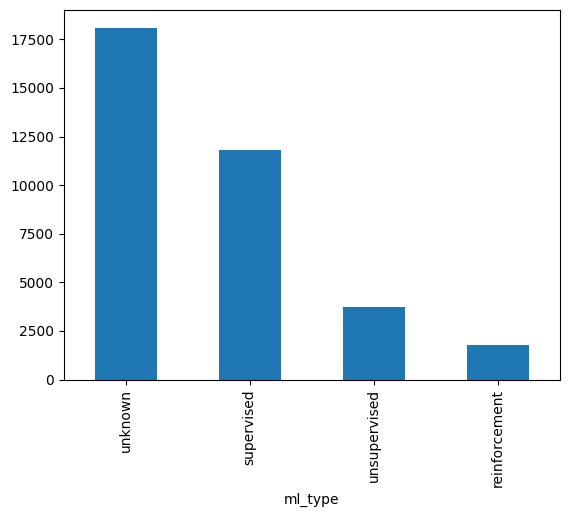

In [15]:
# Plot frequency of ML categories across all abstracts
df["ml_type"].explode().value_counts().plot(kind="bar")

In [16]:
# Sample of abstracts that were classified as "unknown"
df[df["ml_type"].apply(lambda x: x == ["unknown"])].sample(2)


,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,ml_type
31420,ml_predictive_maintenance,2-s2.0-85114124548,10.1109/REPC48665.2021.00009,Mobile Edge Computing Sensors and Cloud Machin...,© 2021 IEEE.The resiliency of the nation's ele...,The resiliency of the nation's electric grid i...,False,False,False,[unknown]
47286,ml_quality_control,2-s2.0-85152013765,10.1109/IC3I56241.2022.10072565,Recent Management Trends Involved with the Int...,© 2022 IEEE.The development of smart manufactu...,The development of smart manufacturing systems...,False,False,False,[unknown]


### Notes on Keyword-Based Classification

The keyword approach provides a simple first pass, but it has clear limitations:
- Many abstracts are labeled **unknown** because keywords may be absent, implicit, or expressed differently.
- Some methods overlap terminology (e.g., “semi-supervised”), which can lead to misclassification.
- Context is ignored, so the presence of a term does not guarantee it is the main ML method.

These limitations explain the large number of “unknown” cases and motivate using a more robust model-based classifier later.

## Training a Multi-Label ML-Method Classifier Using Keyword Pseudo-Labels

- The keyword-based approach provides noisy but useful initial labels for each article (e.g., supervised / unsupervised / reinforcement).  
- In the following steps, we use these pseudo-labels to train a **multi-label transformer model** (e.g., SciBERT or DistilBERT) on the abstracts. 
- This allows the model to learn richer linguistic patterns and produce more accurate classifications than the raw keyword method, while requiring **no manual labeling up front**.


In [17]:
label_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

# Keep only rows that have at least one positive label
df_model = df.copy()
mask_any_label = df_model[label_cols].sum(axis=1) > 0
df_model = df_model[mask_any_label].reset_index(drop=True)

print(df_model[label_cols].mean())  # quick check of label frequencies

# Compute pos_weight for BCEWithLogitsLoss
label_array = df_model[label_cols].astype(int).values  # shape (N, num_labels)
pos_counts = label_array.sum(axis=0)                   # positives per label
neg_counts = len(df_model) - pos_counts                # negatives per label
pos_weight = neg_counts / (pos_counts + 1e-8)          # larger => more weight on positives

print("pos_weight:", pos_weight)  # quick sanity check

dataset = Dataset.from_pandas(df_model[["clean_abs"] + label_cols])

# Train/validation split
splits = dataset.train_test_split(test_size=0.2, seed=42)
train_ds = splits["train"]
val_ds = splits["test"]


is_supervised       0.785016
is_unsupervised     0.249784
is_reinforcement    0.117240
dtype: float64
pos_weight: [0.27385998 3.00346297 7.52951192]


In [18]:
# Ensure scibert directory exists
scibert_path = processed_abstracts_path / "scibert_tuned"
scibert_path.mkdir(parents=True, exist_ok=True)

# Save datasets
train_path = scibert_path / "train_ds.csv"
val_path = scibert_path / "val_ds.csv"

train_ds.to_csv(train_path, index=False)
val_ds.to_csv(val_path, index=False)

print(f"Saved train_ds to: {train_path}")
print(f"Saved val_ds to:   {val_path}")

Creating CSV from Arrow format:   0%|          | 0/13 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Saved train_ds to: ../../data/processed/abstracts/scibert_tuned/train_ds.csv
Saved val_ds to:   ../../data/processed/abstracts/scibert_tuned/val_ds.csv


In [19]:
train_ds.to_pandas().head()


,clean_abs,is_supervised,is_unsupervised,is_reinforcement
0,"However, managing the variability of water qua...",False,True,False
1,V.The prediction of remaining useful life play...,False,True,False
2,V.Accurate prediction of wind speed is one of ...,True,True,False
3,The discovery of induced pluripotent stem cell...,False,False,True
4,"As a typical batch production process, the rub...",True,False,True


In [21]:
model_name = "allenai/scibert_scivocab_uncased"  # or "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

label_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

# Add a single multi-label 'labels' column
def add_labels(example):
    example["labels"] = [float(example[c]) for c in label_cols]
    return example

train_ds_l = train_ds.map(add_labels)
val_ds_l   = val_ds.map(add_labels)

def tokenize_batch(batch):
    return tokenizer(
        batch["clean_abs"],
        padding="max_length",
        truncation=True,
        max_length=512,
    )

train_ds_tok = train_ds_l.map(tokenize_batch, batched=True)
val_ds_tok   = val_ds_l.map(tokenize_batch, batched=True)

def set_format(ds):
    return ds.with_format(
        type="torch",
        columns=["input_ids", "attention_mask", "labels"],
    )

train_ds_tok = set_format(train_ds_tok)
val_ds_tok   = set_format(val_ds_tok)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_cols),
    problem_type="multi_label_classification",
)


Map:   0%|          | 0/12023 [00:00<?, ? examples/s]

Map:   0%|          | 0/3006 [00:00<?, ? examples/s]

Map:   0%|          | 0/12023 [00:00<?, ? examples/s]

Map:   0%|          | 0/3006 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# # Compute average, min and max token length over all abstracts

# lengths = []

# # Ensure all inputs are strings (replace NaN with empty string)
# for text in df["clean_abs"].fillna("").astype(str).tolist():
#     enc = tokenizer(
#         text,
#         truncation=False,      # Do not truncate so we see the true length
#         add_special_tokens=True,
#     )
#     lengths.append(len(enc["input_ids"]))

# avg_len = sum(lengths) / len(lengths)
# max_len = max(lengths)
# min_len = min(lengths)

# print(f"Average token length: {avg_len:.2f}")
# print(f"Min tokens: {min_len}, Max tokens: {max_len}")


Average token length: 259.62
Min tokens: 2, Max tokens: 2709


In [ ]:
print("Tokenizer type:", tokenizer.__class__.__name__)
print("Config max position embeddings:", model.config.max_position_embeddings)

Tokenizer type: BertTokenizerFast
Config max position embeddings: 512


In [ ]:
# # Count how many abstracts exceed various token-length thresholds

# thresholds = [256, 512, 768, 1024, 1500]

# lengths = []
# for text in df["clean_abs"].fillna("").astype(str).tolist():
#     enc = tokenizer(text, truncation=False)   # do NOT truncate -> get true length
#     lengths.append(len(enc["input_ids"]))

# results = {}
# for t in thresholds:
#     results[t] = sum(l > t for l in lengths)

# print("Token length distribution:")
# for t, count in results.items():
#     print(f" > {t:4d} tokens : {count} abstracts")

# # Optional: also show % of dataset
# n = len(lengths)
# print("\nPercentages:")
# for t, count in results.items():
#     print(f" > {t:4d} tokens : {count/n*100:.2f}%")


Token length distribution:
 >  256 tokens : 14734 abstracts
 >  512 tokens : 671 abstracts
 >  768 tokens : 127 abstracts
 > 1024 tokens : 55 abstracts
 > 1500 tokens : 4 abstracts

Percentages:
 >  256 tokens : 44.47%
 >  512 tokens : 2.03%
 >  768 tokens : 0.38%
 > 1024 tokens : 0.17%
 > 1500 tokens : 0.01%


In [ ]:
# # Check cuda version etc for debugging

# print(torch.version.cuda)
# print(torch.cuda.get_device_name())
# print(torch.cuda.get_device_capability())
# print(torch.cuda.get_arch_list())

In [22]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))           # sigmoid
    preds = (probs >= 0.5).astype(int)          # fixed 0.5 threshold for eval

    return {
        "f1_micro": f1_score(labels, preds, average="micro", zero_division=0),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "precision_micro": precision_score(labels, preds, average="micro", zero_division=0),
        "recall_micro": recall_score(labels, preds, average="micro", zero_division=0),
    }

class WeightedTrainer(Trainer):
    # Custom Trainer to use BCEWithLogitsLoss with pos_weight
    def __init__(self, pos_weight=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weight = pos_weight

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Ensure float labels
        if labels.dtype != torch.float32:
            labels = labels.float()

        loss_fct = torch.nn.BCEWithLogitsLoss(
            pos_weight=self.pos_weight.to(logits.device)
        )
        loss = loss_fct(logits, labels)

        if return_outputs:
            return loss, outputs
        return loss

training_args = TrainingArguments(
    output_dir="./ml_type_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    logging_steps=50,
)

pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float32)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_tok,
    eval_dataset=val_ds_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    pos_weight=pos_weight_tensor,
)

trainer.train()


/tmp/ipykernel_3258151/3604657034.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Precision Micro,Recall Micro
1,0.067400,0.094302,0.983692,0.975940,0.981284,0.986111
2,0.034100,0.086151,0.991012,0.985465,0.993027,0.989005
3,0.026400,0.064103,0.991027,0.986646,0.991314,0.990741


TrainOutput(global_step=2256, training_loss=0.09781369791574221, metrics={'train_runtime': 831.996, 'train_samples_per_second': 43.352, 'train_steps_per_second': 2.712, 'total_flos': 9490237864031232.0, 'train_loss': 0.09781369791574221, 'epoch': 3.0})

In [23]:
# Get raw logits and labels on validation set
val_outputs = trainer.predict(val_ds_tok)
val_logits = val_outputs.predictions               # shape (N, num_labels)
val_labels = val_outputs.label_ids                 # shape (N, num_labels)
val_probs = 1 / (1 + np.exp(-val_logits))

best_thresholds = []

for j, col in enumerate(label_cols):
    y_true = val_labels[:, j]
    if y_true.sum() == 0:
        # If no positives, keep default 0.5
        best_thresholds.append(0.5)
        continue

    candidate_ts = np.linspace(0.5, 0.9, 17)      # tune between 0.5 and 0.9
    best_f1, best_t = 0.0, 0.5
    for t in candidate_ts:
        y_pred = (val_probs[:, j] >= t).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    print(col, "best_t:", best_t, "f1:", best_f1)
    best_thresholds.append(best_t)

best_thresholds = np.array(best_thresholds)
print("Per-label thresholds:", best_thresholds)


is_supervised best_t: 0.5 f1: 0.9944727891156463
is_unsupervised best_t: 0.825 f1: 0.9893048128342246
is_reinforcement best_t: 0.8 f1: 0.9814550641940085
Per-label thresholds: [0.5   0.825 0.8  ]


In [ ]:
best_thresholds = [0.5, 0.825, 0.8]

In [27]:
def predict_ml_types_batched(texts, trainer, thresholds=0.5, batch_size=64, max_length=512):
    all_preds = []
    all_probs = []

    model = trainer.model
    model.eval()

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        enc = {k: v.to(model.device) for k, v in enc.items()}

        with torch.no_grad():
            logits = model(**enc).logits

        probs = torch.sigmoid(logits).cpu().numpy()

        # thresholds can be scalar or array-like of shape (num_labels,)
        preds = (probs >= thresholds).astype(int)

        all_probs.append(probs)
        all_preds.append(preds)

    all_probs = np.vstack(all_probs)
    all_preds = np.vstack(all_preds)
    return all_preds, all_probs

# Ensure clean_abs has only string values
df["clean_abs"] = df["clean_abs"].fillna("")        # replace NaN/None with empty string
df["clean_abs"] = df["clean_abs"].astype(str)       # force everything to string

texts = df["clean_abs"].tolist()

# Use per-label thresholds found on validation set
preds, probs = predict_ml_types_batched(
    texts,
    trainer,
    thresholds=best_thresholds,
    batch_size=64,
    max_length=512,
)

for i, col in enumerate(label_cols):
    df[f"pred_{col}"] = preds[:, i]


In [28]:
for i, col in enumerate(label_cols):
    df[f"pred_{col}"] = preds[:, i]

pred_cols = [f"pred_{c}" for c in label_cols]
cols_to_save = [
    "query_id", "eid", "doi", "title", "abstract", "clean_abs",
] + label_cols + pred_cols

save_path = scibert_path / "abstracts_with_predictions.csv"
df[cols_to_save].to_csv(save_path, index=False)

print(f"Saved predictions to: {save_path}")

Saved predictions to: ../../data/processed/abstracts/scibert_tuned/abstracts_with_predictions.csv


## Analyze Scibert Predictions

In [2]:
pred_path = Path("../../data/processed/abstracts/scibert_tuned/abstracts_with_predictions.csv")

pred_cols = ["pred_is_supervised","pred_is_unsupervised","pred_is_reinforcement"]

In [3]:
df = pd.read_csv(pred_path)
df.head()

,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
0,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...,False,False,False,0,0,1
1,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta...",False,False,False,0,0,0
2,ml_end_of_life,2-s2.0-105009033696,10.1109/TEMSCON-ASPAC62480.2024.11025082,Clustering Locations of Collection Centers in ...,© 2024 IEEE.Waste generation is a significant ...,Waste generation is a significant issue in sus...,False,True,True,0,1,1
3,ml_end_of_life,2-s2.0-85178021268,10.1188/23.CJON.595-601,"Artificial Intelligence: Basics, Impact, and H...","© 2023, Oncology Nursing Society. All rights r...",All rights reserved.Applying artificial intell...,False,False,False,0,0,0
4,ml_end_of_life,2-s2.0-85176777527,10.1039/d3va00106g,Intersections between materials science and ma...,© 2023 RSCPlastics are an integral part of the...,"However, their widespread contamination in the...",False,False,False,0,1,0


In [6]:
# Number of unique DOIs

num_unique_dois = df["doi"].nunique()
print(f"Number of unique DOIs: {num_unique_dois}")

Number of unique DOIs: 33129


In [7]:
df[pred_cols].mean()

pred_is_supervised       0.703562
pred_is_unsupervised     0.132025
pred_is_reinforcement    0.137549
dtype: float64

In [17]:
# Labels for plotting
label_map = {
    "pred_is_supervised": "supervised",
    "pred_is_unsupervised": "unsupervised",
    "pred_is_reinforcement": "reinforcement",
}


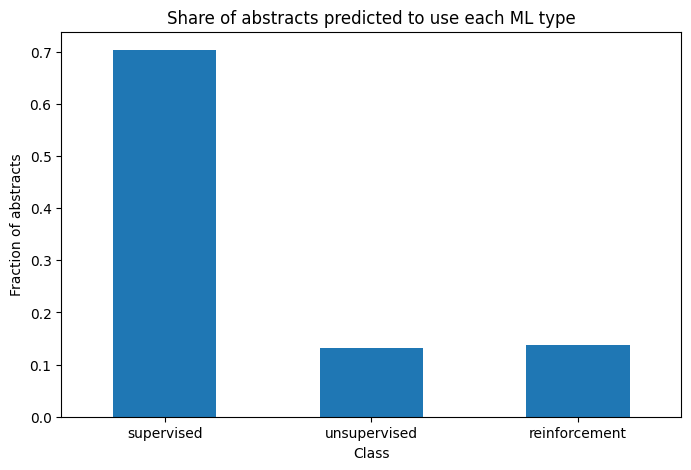

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))

df[pred_cols].mean().plot(kind="bar", ax=ax)

ax.set_title("Share of abstracts predicted to use each ML type")
ax.set_xlabel("Class")
ax.set_ylabel("Fraction of abstracts")

ax.set_xticklabels(
    [label_map[c] for c in pred_cols],
    rotation=0
)

fig.savefig(
    figure_path / "ml_type_prediction_share.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


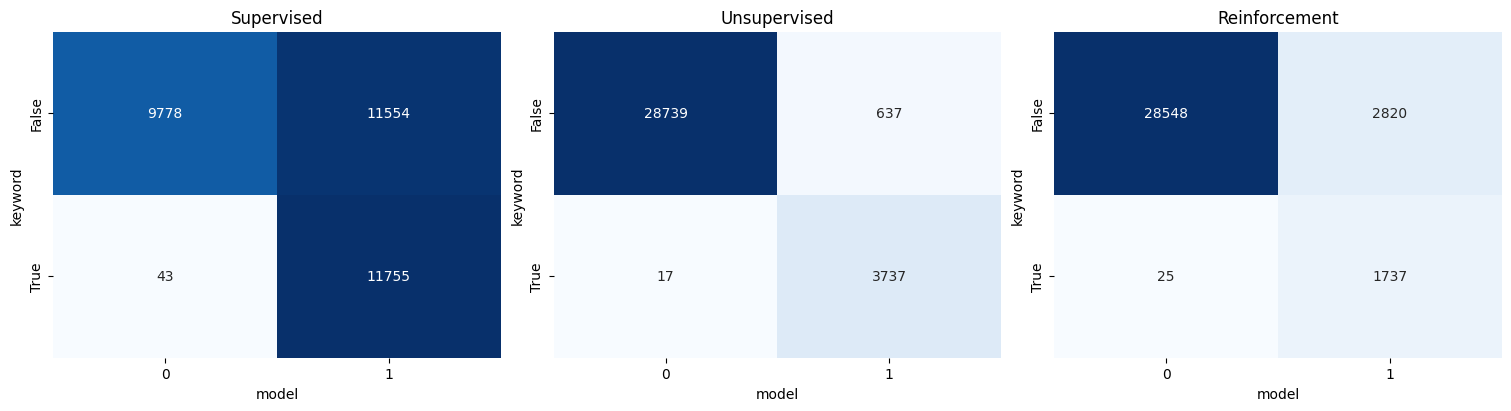

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

label_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

for ax, col in zip(axes, label_cols):
    ctab = pd.crosstab(df[col], df[f"pred_{col}"], rownames=["keyword"], colnames=["model"])
    
    sns.heatmap(
        ctab,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=ax
    )
    ax.set_title(col.replace("is_", "").capitalize())

plt.show()


In [12]:
# Small per-label stats
for col in label_cols:
    pred = df[f"pred_{col}"]
    true = df[col]

    tp = ((true == 1) & (pred == 1)).sum()
    fp = ((true == 0) & (pred == 1)).sum()
    fn = ((true == 1) & (pred == 0)).sum()
    tn = ((true == 0) & (pred == 0)).sum()

    print(
        f"\n=== {col} ===\n"
        f"TP: {tp}\nFP: {fp}\nFN: {fn}\nTN: {tn}\n"
        f"Precision: {tp/(tp+fp+1e-9):.3f}\n"
        f"Recall:    {tp/(tp+fn+1e-9):.3f}\n"
    )



=== is_supervised ===
TP: 11755
FP: 11554
FN: 43
TN: 9778
Precision: 0.504
Recall:    0.996


=== is_unsupervised ===
TP: 3737
FP: 637
FN: 17
TN: 28739
Precision: 0.854
Recall:    0.995


=== is_reinforcement ===
TP: 1737
FP: 2820
FN: 25
TN: 28548
Precision: 0.381
Recall:    0.986



In [13]:
# Extract a few rows where the model disagrees with keyword labels (only among keyword-labeled rows)

mask_labeled = df[label_cols].sum(axis=1) > 0
mask_disagree = (df[[f"pred_{c}" for c in label_cols]].values != df[label_cols].values).any(axis=1)

df_mismatch = df[mask_labeled & mask_disagree]

df_mismatch.sample(10)[
    ["doi", "title", "clean_abs"] 
    + label_cols 
    + [f"pred_{c}" for c in label_cols]
]


,doi,title,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
11040,10.1109/ICCAIS63750.2024.10814271,Anomaly Detection in Dynamic Power Events Usin...,This paper describes a methodology to detect a...,False,False,True,0,1,1
24143,10.12732/ijam.v38i2s.73,ADAPTIVE PAYMENT ROUTING IN E-COMMERCE: A MACH...,Ltd.. All rights reserved.Online stores need t...,True,False,True,1,1,0
22412,10.1016/j.jenvman.2023.117286,Aleppo pine seeds (Pinus halepensis Mill.) as ...,Concerns about the long-term impact of non-bio...,False,False,True,1,0,1
26611,10.1109/ICDCS59278.2024.10560983,Stability Approximation of Gel Electrolytes Us...,The research proposed work Machine learning-ba...,True,False,True,1,0,0
2095,10.1109/INDIN41052.2019.8972081,Using anomaly detection to support classificat...,In this paper we propose a new method to assis...,True,True,False,0,1,0
4966,10.1109/NIGERCON62786.2024.10927105,A Two-stage Anomaly Detection System for Fog C...,Fog computing enhances traditional cloud compu...,False,True,False,1,1,0
26462,10.1109/ICAIIC60209.2024.10463497,Leveraging OpenAPI for Microservice Decomposit...,The demand for greater modularity and scalabil...,True,True,False,0,1,0
29579,10.3390/app9245379,Determination of clamping force using bolt vib...,This paper presents a novel method to measure ...,True,True,False,0,1,0
17831,10.1017/dce.2025.7,Active learning for regression in engineering ...,Regression is a fundamental prediction task co...,True,False,True,1,0,0
11453,10.1016/j.promfg.2018.07.143,Interdisciplinary Data Driven Production Proce...,Recent developments in the industrial field ar...,True,False,False,1,0,1


In [14]:
# Compare prediction counts for rows used in training vs rows not used in training

# Identify which rows were used for training (those with at least one keyword-label = 1)
mask_train = df[label_cols].sum(axis=1) > 0
mask_not_train = ~mask_train

# Count predicted positives per class for train rows
pred_cols = [f"pred_{c}" for c in label_cols]

pred_counts_train = df[mask_train][pred_cols].sum()
pred_counts_not_train = df[mask_not_train][pred_cols].sum()

print("Predictions on TRAINED rows ")
print(pred_counts_train)
print("\nPredictions on NON-TRAINED rows ")
print(pred_counts_not_train)


Predictions on TRAINED rows 
pred_is_supervised       11782
pred_is_unsupervised      3752
pred_is_reinforcement     1742
dtype: int64

Predictions on NON-TRAINED rows 
pred_is_supervised       11527
pred_is_unsupervised       622
pred_is_reinforcement     2815
dtype: int64


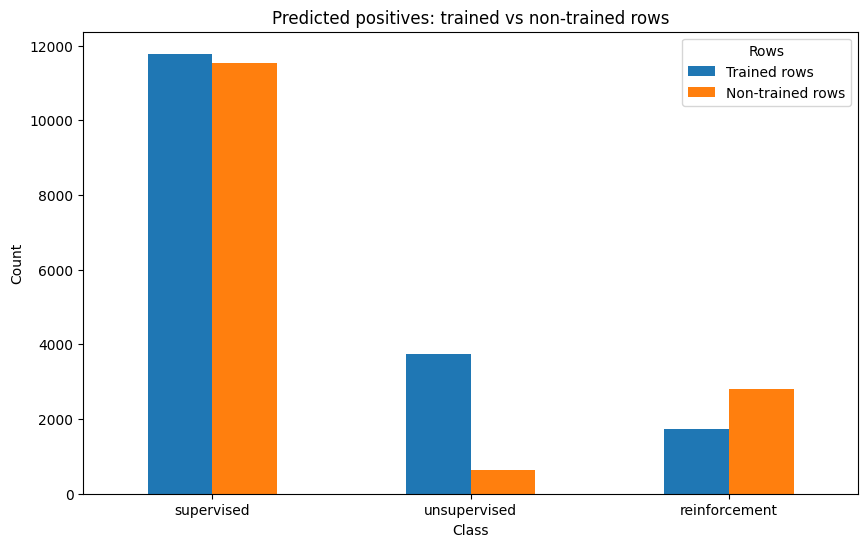

In [ ]:
pred_counts_df = pd.DataFrame(
    {
        "Trained rows": pred_counts_train,
        "Non-trained rows": pred_counts_not_train,
    },
    index=pred_cols
)

fig, ax = plt.subplots(figsize=(10, 6))
pred_counts_df.plot(kind="bar", ax=ax)

ax.set_title("Predicted positives: trained vs non-trained rows")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
ax.legend(title="Rows")

ax.set_xticklabels(
    [label_map[c] for c in pred_counts_df.index],
    rotation=0
)

fig.savefig(
    figure_path / "predicted_positives_trained_vs_non_trained.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


In [11]:
# Number of still unknown abstracts after model predictions
mask_unknown = df[[f"pred_{c}" for c in label_cols]].sum(axis=1) == 0
num_unknown = mask_unknown.sum()
total = len(df)
print(f"Number of abstracts still unknown after predictions: {num_unknown} / {total} ({num_unknown/total*100:.2f}%)")

Number of abstracts still unknown after predictions: 3293 / 33130 (9.94%)


## Extract rows for manual labeling

In [12]:
# Ensure we work on a clean copy
df_copy = df.copy()

label_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

# Define category masks
mask_supervised = df_copy["is_supervised"] == 1
mask_unsupervised = df_copy["is_unsupervised"] == 1
mask_reinforcement = df_copy["is_reinforcement"] == 1
mask_unknown = df_copy[label_cols].sum(axis=1) == 0   # no labels at all

# Function to sample up to 50 rows per category
def sample_category(mask, n=50):
    subset = df_copy[mask]
    if len(subset) == 0:
        return pd.DataFrame(columns=["doi", "clean_abs", "category"])
    return subset.sample(n=min(n, len(subset)), random_state=42)

# Sample each category
df_sup = sample_category(mask_supervised)
df_sup["category"] = "supervised"

df_unsup = sample_category(mask_unsupervised)
df_unsup["category"] = "unsupervised"

df_rl = sample_category(mask_reinforcement)
df_rl["category"] = "reinforcement"

df_unknown = sample_category(mask_unknown)
df_unknown["category"] = "unknown"

# Combine
df_sampled = pd.concat([df_sup, df_unsup, df_rl, df_unknown], ignore_index=True)

# Keep only DOI + abstract + category
df_final = df_sampled[["doi", "category", "clean_abs"]]

# Save to CSV
output_path = "manual_label_sample.csv"
df_final.to_csv(output_path, index=False)

print(f"Saved {len(df_final)} samples to {output_path}")
df_final.head()


Saved 200 samples to manual_label_sample.csv


,doi,category,clean_abs
0,10.23940/ijpe.21.02.p7.229240,supervised,Carbide cutting tools form an essential part o...
1,10.5937/zasmat2303308D,supervised,distributed under.The textile products are aff...
2,10.1007/978-3-030-29859-3_43,supervised,Steel-making process is a complex procedure in...
3,10.1007/978-981-15-8289-9_5,supervised,The assessment of the product development init...
4,10.2175/193864718825159678,supervised,The shift towards energy-efficient wastewater ...
